In [1]:
import sys
sys.path.append('../')
import pandas as pd
from Generation.VAE_model import VAE
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import utils.custom_dataset
from sklearn.decomposition import PCA
annotation_path = "../Data/data/preprocessed_annotation_global.csv"
y = pd.read_csv(annotation_path)["label"]
names = y.astype('category').cat.categories
y = y.astype('category').cat.codes
seed = 1200
meth_path = "../Data/data/preprocessed_Matrix_meth.csv"
mRNA_path = "../Data/data/preprocessed_Matrix_miRNA_deseq_correct.csv"
mRNA_normalized_path = "../Data/data/preprocessed_Matrix_mRNA_deseq_normalized_prot_coding_correct.csv"
files = [mRNA_path,meth_path,mRNA_normalized_path]
filenames = ["meth","mrna","micro mrna"]

In [2]:
names

Index(['sane-TCGA-KIRC', 'sane-TCGA-KIRP', 'tumor-TCGA-KICH',
       'tumor-TCGA-KIRC', 'tumor-TCGA-KIRP'],
      dtype='object')

meth
mrna
micro mrna


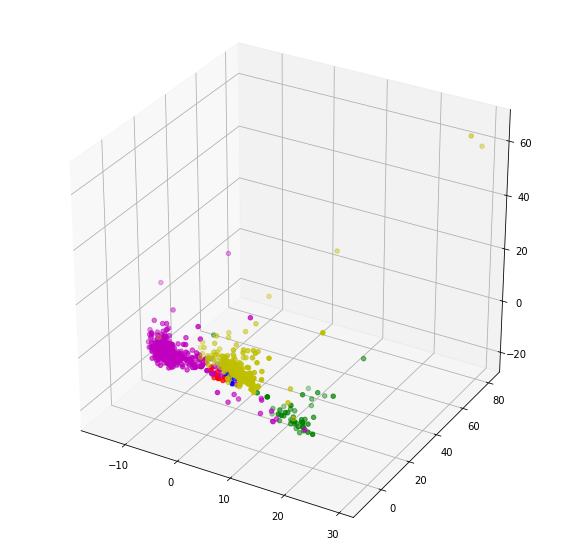

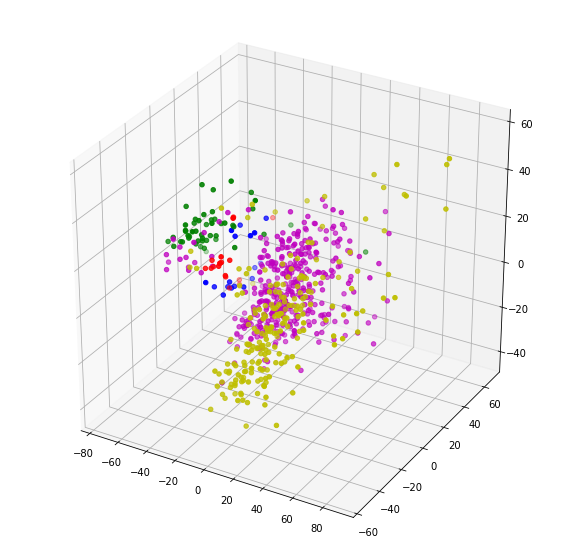

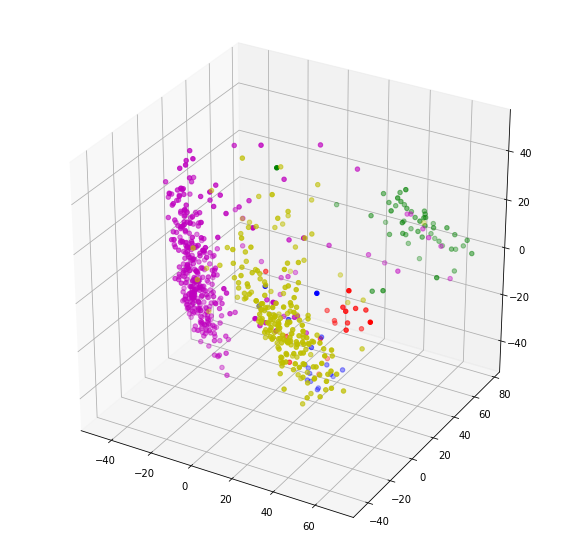

In [3]:
for file,filename in zip(files,filenames):
    outputname=filename
    y = pd.read_csv(annotation_path)["label"].astype('category').cat.codes
    X= pd.read_csv(file,index_col=False,header=None)
    X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=seed,stratify=y)
    pca= PCA(n_components=3)
    X= pca.fit_transform(X_train)
    y=y_train
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.scatter(X[y==0,0],X[y==0,1],X[y==0,2],c='r')
    ax.scatter(X[y==1,0],X[y==1,1],X[y==1,2],c='b')
    ax.scatter(X[y==2,0],X[y==2,1],X[y==2,2],c='g')
    ax.scatter(X[y==3,0],X[y==3,1],X[y==3,2],c='m')
    ax.scatter(X[y==4,0],X[y==4,1],X[y==4,2],c='y')
    print(filename)


meth
mrna
micro mrna


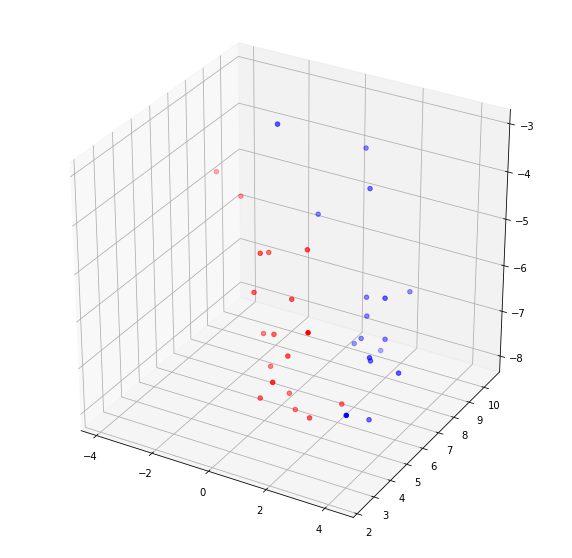

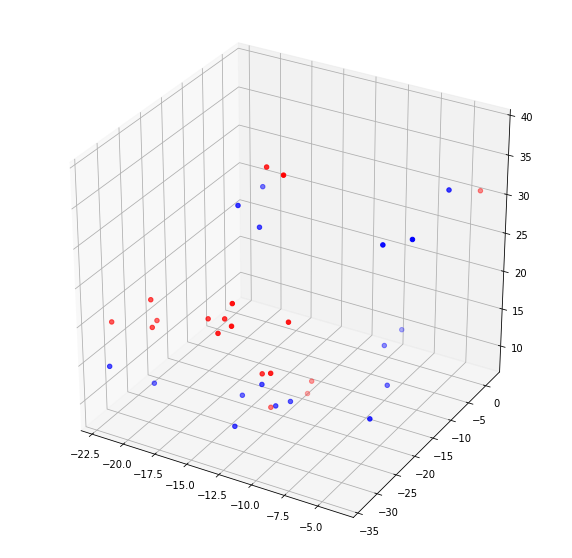

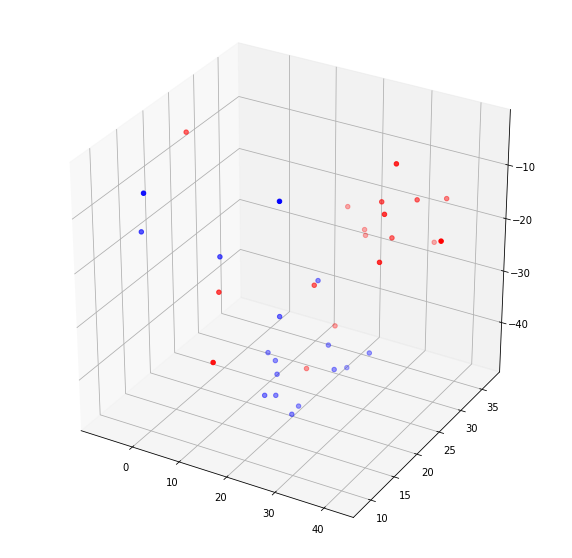

In [4]:
for file,filename in zip(files,filenames):
    outputname=filename
    y = pd.read_csv(annotation_path)["label"].astype('category').cat.codes
    X= pd.read_csv(file,index_col=False,header=None)
    X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=seed,stratify=y)
    pca= PCA(n_components=3)
    X= pca.fit_transform(X_train)
    y=y_train
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.scatter(X[y==0,0],X[y==0,1],X[y==0,2],c='r')
    ax.scatter(X[y==1,0],X[y==1,1],X[y==1,2],c='b')
    plt.savefig("original"+filename+".png")
    print(filename)

original silhoutte:
0.3796706036426282
Train Epoch: 99 [2/18 (50%)]	Loss: 8.330940
Train Epoch: 99 [1/17 (50%)]	Loss: 3.622907
Train Epoch: 99 [3/49 (75%)]	Loss: 2078.963379
Train Epoch: 99 [299/381 (96%)]	Loss: nan
Train Epoch: 99 [104/216 (93%)]	Loss: nan
meth
original silhoutte:
0.14937701076267543
Train Epoch: 99 [2/18 (50%)]	Loss: 38558.820312
Train Epoch: 99 [1/17 (50%)]	Loss: 35498.187500
Train Epoch: 99 [3/49 (75%)]	Loss: nan


KeyboardInterrupt: 

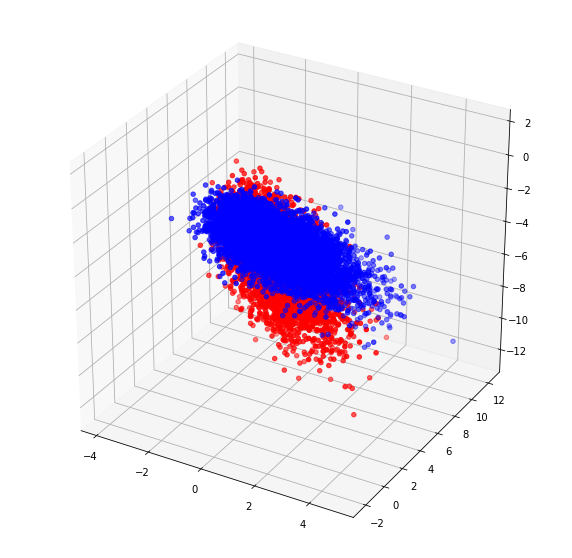

In [5]:
for file, filename in zip(files, filenames):
    y = pd.read_csv(annotation_path)["label"].astype('category').cat.codes
    X = pd.read_csv(file,index_col=False,header=None)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed,stratify=y)
    pca= PCA(n_components=3)
    X_train= pca.fit_transform(X_train)
    print("original silhoutte:")
    print(silhouette_score(X_train,y_train))
    number_per_class =500
    X_train_new = pd.DataFrame(np.ndarray((0,X_train.shape[1])))
    y_train_new = pd.Series(np.ndarray(()))
    for label in range(5):
        X_train_temp = X_train[y_train==label].copy()
        y_train_temp = y_train[y_train==label].copy()

        dataset = utils.custom_dataset.CustomDataset(X_train_temp, y_train_temp.to_numpy(),
                                                     transform=utils.custom_dataset.ToTensor())
        loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
        model= VAE(X_train_temp.shape[1])
        number_per_class=10000
        model.train_model(100,loader)
        sample = torch.randn(number_per_class-(y_train_temp==label).sum(), 5000).to(model.device)
        sample = model.decode(sample).cpu()
        X_train_temp = pd.DataFrame(np.append(X_train_temp, sample.detach().numpy(), axis=0))
        y_train_temp = pd.Series(np.append(y_train_temp.values, np.ones((number_per_class - (y_train_temp == label).sum(),)) * label, axis=0))
        X_train_new=pd.DataFrame(np.append(X_train_new.to_numpy(),X_train_temp,axis=0))
        y_train_new=pd.Series(np.append(y_train_new.to_numpy(),y_train_temp.to_numpy(),axis=0))
    y_train_new=y_train_new.drop(index=0)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    X_train_new=X_train_new.to_numpy()
    ax.scatter(X_train_new[y_train_new==0,0],X_train_new[y_train_new==0,1],X_train_new[y_train_new==0,2],c='r')
    ax.scatter(X_train_new[y_train_new==1,0],X_train_new[y_train_new==1,1],X_train_new[y_train_new==1,2],c='b')
    plt.savefig("augmented"+filename+".png")
    print(filename)

In [ ]:
for file, filename in zip(files, filenames):

    X = pd.read_csv(file,index_col=False,header=None)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed,stratify=y)
    pca= PCA(n_components=3)
    X_train= pca.fit_transform(X_train)
    print("original silhoutte:")
    print(silhouette_score(X_train,y_train))
    number_per_class =1000
    X_train_new = pd.DataFrame(np.ndarray((0,X_train.shape[1])))
    y_train_new = pd.Series(np.ndarray(()))
    for label in range(5):
        X_train_temp = X_train[y_train==label].copy()
        y_train_temp = y_train[y_train==label].copy()

        dataset = utils.custom_dataset.CustomDataset(X_train_temp, y_train_temp.to_numpy(),
                                                     transform=utils.custom_dataset.ToTensor())
        loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
        model= VAE(X_train_temp.shape[1])
        number_per_class=10000
        model.train_model(30,loader)
        sample = torch.randn(number_per_class-(y_train_temp==label).sum(),5000).to(model.device)
        sample = model.decode(sample).cpu()
        
        X_train_new = pd.DataFrame(np.append(X_train_new, sample.detach().numpy(), axis=0))
        y_train_new = pd.Series(np.append(y_train_new.values, np.ones((number_per_class - (y_train_temp == label).sum(),)) * label, axis=0))
        #X_train_new=pd.DataFrame(np.append(X_train_new.to_numpy(),X_train_temp,axis=0))
        #y_train_new=pd.Series(np.append(y_train_new.to_numpy(),y_train_temp.to_numpy(),axis=0))
    y_train_new=y_train_new.drop(index=0)
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    X_train_new=X_train_new.to_numpy()
    ax.scatter(X_train_new[y_train_new==0,0],X_train_new[y_train_new==0,1],X_train_new[y_train_new==0,2],c='r')
    ax.scatter(X_train_new[y_train_new==1,0],X_train_new[y_train_new==1,1],X_train_new[y_train_new==1,2],c='b')
    #ax.scatter(X_train_new[y_train_new==2,0],X_train_new[y_train_new==2,1],X_train_new[y_train_new==2,2],c='g')
    #ax.scatter(X_train_new[y_train_new==3,0],X_train_new[y_train_new==3,1],X_train_new[y_train_new==3,2],c='m')
    #ax.scatter(X_train_new[y_train_new==4,0],X_train_new[y_train_new==4,1],X_train_new[y_train_new==4,2],c='y')
    print(filename)